# AlphaFold Predicted Structures Analysis

In [1]:
from Bio.PDB import PDBParser, Superimposer, PPBuilder
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
parser = PDBParser(QUIET=True)

In [3]:
# select CA atoms
def get_ca_atoms(structure):
    model = structure[0]  
    chain = list(model.get_chains())[0] 
    return [res["CA"] for res in chain if "CA" in res][:185]

In [4]:
def get_rmsds(folder, wt_atoms):
    rmsds = {}
    files = [f for f in os.listdir(folder) if f.endswith('.pdb')]
    for file in files:
                
        atoms = get_ca_atoms(parser.get_structure("pred", f"{folder}/{file}"))
        
        assert len(atoms) == len(wt_atoms)
        
        sup = Superimposer()
        sup.set_atoms(atoms, wt_atoms)

        sample = file.split('_')[0]
        
        rmsds[sample] = sup.rms
        
        # print(f"RMSD: {sup.rms:.3f} Å")
        
    return rmsds

### Get RMSDs between AlphaFold Predicted PncA variants and the WT (AlphaFold prediction)

In [5]:
af_wt_struct = parser.get_structure("wt", '../pdb/wt/af_wt.pdb')
af_wt_atoms = get_ca_atoms(af_wt_struct)

In [6]:
test_rmsds = get_rmsds("../pdb/test_pza", af_wt_atoms)
train_rmsds = get_rmsds("../pdb/train_pza", af_wt_atoms)

In [7]:
test_df = pd.DataFrame(test_rmsds.items(), columns=['Sample', 'RMSD']).set_index('Sample')
test_df.index = test_df.index.astype(int)
test_df.sort_index(inplace=True)

train_df = pd.DataFrame(train_rmsds.items(), columns=['Sample', 'RMSD']).set_index('Sample')
train_df.index = train_df.index.astype(int)
train_df.sort_index(inplace=True)

### Get phenotypes

In [8]:
train_seqs = pd.read_csv('../data/real_train_sequences.csv')
test_seqs = pd.read_csv('../data/real_test_sequences.csv')

In [9]:
train_df = pd.merge(train_df, train_seqs['phenotype_label'], left_index=True, right_index=True)
test_df = pd.merge(test_df, test_seqs['phenotype_label'], left_index=True, right_index=True)

In [10]:
train_df['Dataset'] = 'Train Set'
test_df['Dataset'] = 'Test Set'

In [11]:
full_set_df = pd.concat([train_df, test_df]).reset_index(drop=True)
full_set_df

,RMSD,phenotype_label,Dataset
0,0.132045,S,Train Set
1,0.090405,S,Train Set
2,0.093664,R,Train Set
3,0.077379,S,Train Set
4,0.253758,R,Train Set
...,...,...,...
659,0.334187,R,Test Set
660,0.082294,S,Test Set
661,0.067970,S,Test Set
662,0.047777,S,Test Set


### Table of mean RMSDs

In [12]:
def get_mean_std_rmsd(phenotype=None, dataset=None):
    subset = full_set_df
    if phenotype:
        subset = subset[subset['phenotype_label'] == phenotype]
    if dataset:
        subset = subset[subset['Dataset'] == dataset]
    print(f"Dataset = {dataset if dataset else 'Full'}. Phenotype = {phenotype if phenotype else 'All'}. \nmean = {subset['RMSD'].mean():.3f}, std = {subset['RMSD'].std():.3f}")

In [13]:
get_mean_std_rmsd()
get_mean_std_rmsd(dataset='Train Set')
get_mean_std_rmsd(dataset='Test Set')
print("\n")
get_mean_std_rmsd(phenotype='R')
get_mean_std_rmsd(phenotype='S')
print("\n")
get_mean_std_rmsd(phenotype='R', dataset='Train Set')
get_mean_std_rmsd(phenotype='S', dataset='Train Set')
print("\n")
get_mean_std_rmsd(phenotype='R', dataset='Test Set')
get_mean_std_rmsd(phenotype='S', dataset='Test Set')

Dataset = Full. Phenotype = All. 
mean = 0.107, std = 0.074
Dataset = Train Set. Phenotype = All. 
mean = 0.105, std = 0.069
Dataset = Test Set. Phenotype = All. 
mean = 0.111, std = 0.086


Dataset = Full. Phenotype = R. 
mean = 0.122, std = 0.076
Dataset = Full. Phenotype = S. 
mean = 0.090, std = 0.069


Dataset = Train Set. Phenotype = R. 
mean = 0.119, std = 0.069
Dataset = Train Set. Phenotype = S. 
mean = 0.089, std = 0.066


Dataset = Test Set. Phenotype = R. 
mean = 0.127, std = 0.093
Dataset = Test Set. Phenotype = S. 
mean = 0.093, std = 0.075


### Sort and choose VMD images by RMSD

Get top and bottom 10 structures by RMSD

In [14]:
test_muts = pd.read_csv('../data/real_test_sequences.csv')[['phenotype_label', 'mutation']]
train_muts = pd.read_csv('../data/real_train_sequences.csv')[['phenotype_label', 'mutation']]

In [15]:
train_muts.reset_index().rename(columns={'index': 'Sample'})

,Sample,phenotype_label,mutation
0,0,S,A102V
1,1,S,A134D
2,2,R,A134P
3,3,S,A134S
4,4,R,A134V
...,...,...,...
459,459,S,Y34H
460,460,S,Y64N
461,461,S,Y95H
462,462,S,Y99C


In [16]:
train_df_w_mut = train_df.reset_index().merge(
    train_muts.reset_index().rename(columns={'index': 'Sample'}), on=['phenotype_label', 'Sample'])

test_df_w_mut = test_df.reset_index().merge(
    test_muts.reset_index().rename(columns={'index': 'Sample'}), on=['phenotype_label', 'Sample'])

In [17]:
train_df_w_mut.set_index('Sample', inplace=True)
test_df_w_mut.set_index('Sample', inplace=True)

In [18]:
full_set_df_w_mut = pd.concat([train_df_w_mut, test_df_w_mut]).reset_index()
full_set_df_w_mut.sort_values(by='RMSD', ascending=False, inplace=True)

In [19]:
display(full_set_df_w_mut.head(10))
display(full_set_df_w_mut.tail(10))

,Sample,RMSD,phenotype_label,Dataset,mutation
628,164,0.539620,R,Test Set,T142R
572,108,0.484756,R,Test Set,L172P
431,431,0.465885,R,Train Set,V180F
545,81,0.420554,R,Test Set,G97V
35,35,0.398973,S,Train Set,A39E
579,115,0.397053,S,Test Set,L35R
91,91,0.387320,S,Train Set,D40E
334,334,0.376910,S,Train Set,S185C
580,116,0.376015,S,Test Set,L35V
411,411,0.371025,R,Train Set,V131F


,Sample,RMSD,phenotype_label,Dataset,mutation
9,9,0.039887,S,Train Set,A152S
267,267,0.039259,S,Train Set,N112H
172,172,0.039088,S,Train Set,G60R
332,332,0.038990,R,Train Set,S179N
483,19,0.038981,S,Test Set,A79S
663,199,0.038383,S,Test Set,Y99F
85,85,0.037669,S,Train Set,D166H
120,120,0.037428,S,Train Set,E111K
356,356,0.035670,S,Train Set,S84C
604,140,0.030654,S,Test Set,Q141E


In [20]:
# get labels for images (top 10)
for _, row in full_set_df_w_mut[:10].iterrows():
    sample = row['Sample']
    mutation = row['mutation']
    phenotype = row['phenotype_label']
    rmsd = row['RMSD']
    dataset = row['Dataset'].split()[0]
    
    label = f"{dataset} {sample}\n{mutation} - {phenotype} - {rmsd:.3f} Å"

    print(label, '\n')

Test 164
T142R - R - 0.540 Å 

Test 108
L172P - R - 0.485 Å 

Train 431
V180F - R - 0.466 Å 

Test 81
G97V - R - 0.421 Å 

Train 35
A39E - S - 0.399 Å 

Test 115
L35R - S - 0.397 Å 

Train 91
D40E - S - 0.387 Å 

Train 334
S185C - S - 0.377 Å 

Test 116
L35V - S - 0.376 Å 

Train 411
V131F - R - 0.371 Å 



In [21]:
# bottom 10
for _, row in full_set_df_w_mut.tail(10).iterrows():
    sample = row['Sample']
    mutation = row['mutation']
    phenotype = row['phenotype_label']
    rmsd = row['RMSD']
    dataset = row['Dataset'].split()[0]
    
    label = f"{dataset} {sample}\n{mutation} - {phenotype} - {rmsd:.3f} Å"
    
    print(label, '\n')

Train 9
A152S - S - 0.040 Å 

Train 267
N112H - S - 0.039 Å 

Train 172
G60R - S - 0.039 Å 

Train 332
S179N - R - 0.039 Å 

Test 19
A79S - S - 0.039 Å 

Test 199
Y99F - S - 0.038 Å 

Train 85
D166H - S - 0.038 Å 

Train 120
E111K - S - 0.037 Å 

Train 356
S84C - S - 0.036 Å 

Test 140
Q141E - S - 0.031 Å 



In [22]:
# get image paths
for _, row in full_set_df_w_mut.head(10).iterrows():
    number = row['Sample']
    folder = 'train_structures' if row['Dataset'] == 'Train Set' else 'test_structures'
    
    path = f'{folder}/renders/{number}.png'
    print('\\' + path + ' \\')

\test_structures/renders/164.png \
\test_structures/renders/108.png \
\train_structures/renders/431.png \
\test_structures/renders/81.png \
\train_structures/renders/35.png \
\test_structures/renders/115.png \
\train_structures/renders/91.png \
\train_structures/renders/334.png \
\test_structures/renders/116.png \
\train_structures/renders/411.png \


In [23]:
for _, row in full_set_df_w_mut.tail(10).iterrows():
    number = row['Sample']
    folder = 'train_structures' if row['Dataset'] == 'Train Set' else 'test_structures'
    
    path = f'{folder}/renders/{number}.png'
    print('\\' + path + ' \\')

\train_structures/renders/9.png \
\train_structures/renders/267.png \
\train_structures/renders/172.png \
\train_structures/renders/332.png \
\test_structures/renders/19.png \
\test_structures/renders/199.png \
\train_structures/renders/85.png \
\train_structures/renders/120.png \
\train_structures/renders/356.png \
\test_structures/renders/140.png \


## Figures

### Distribution of RMSDs for S and R

Not normal distribution; Mann-Whitney U test

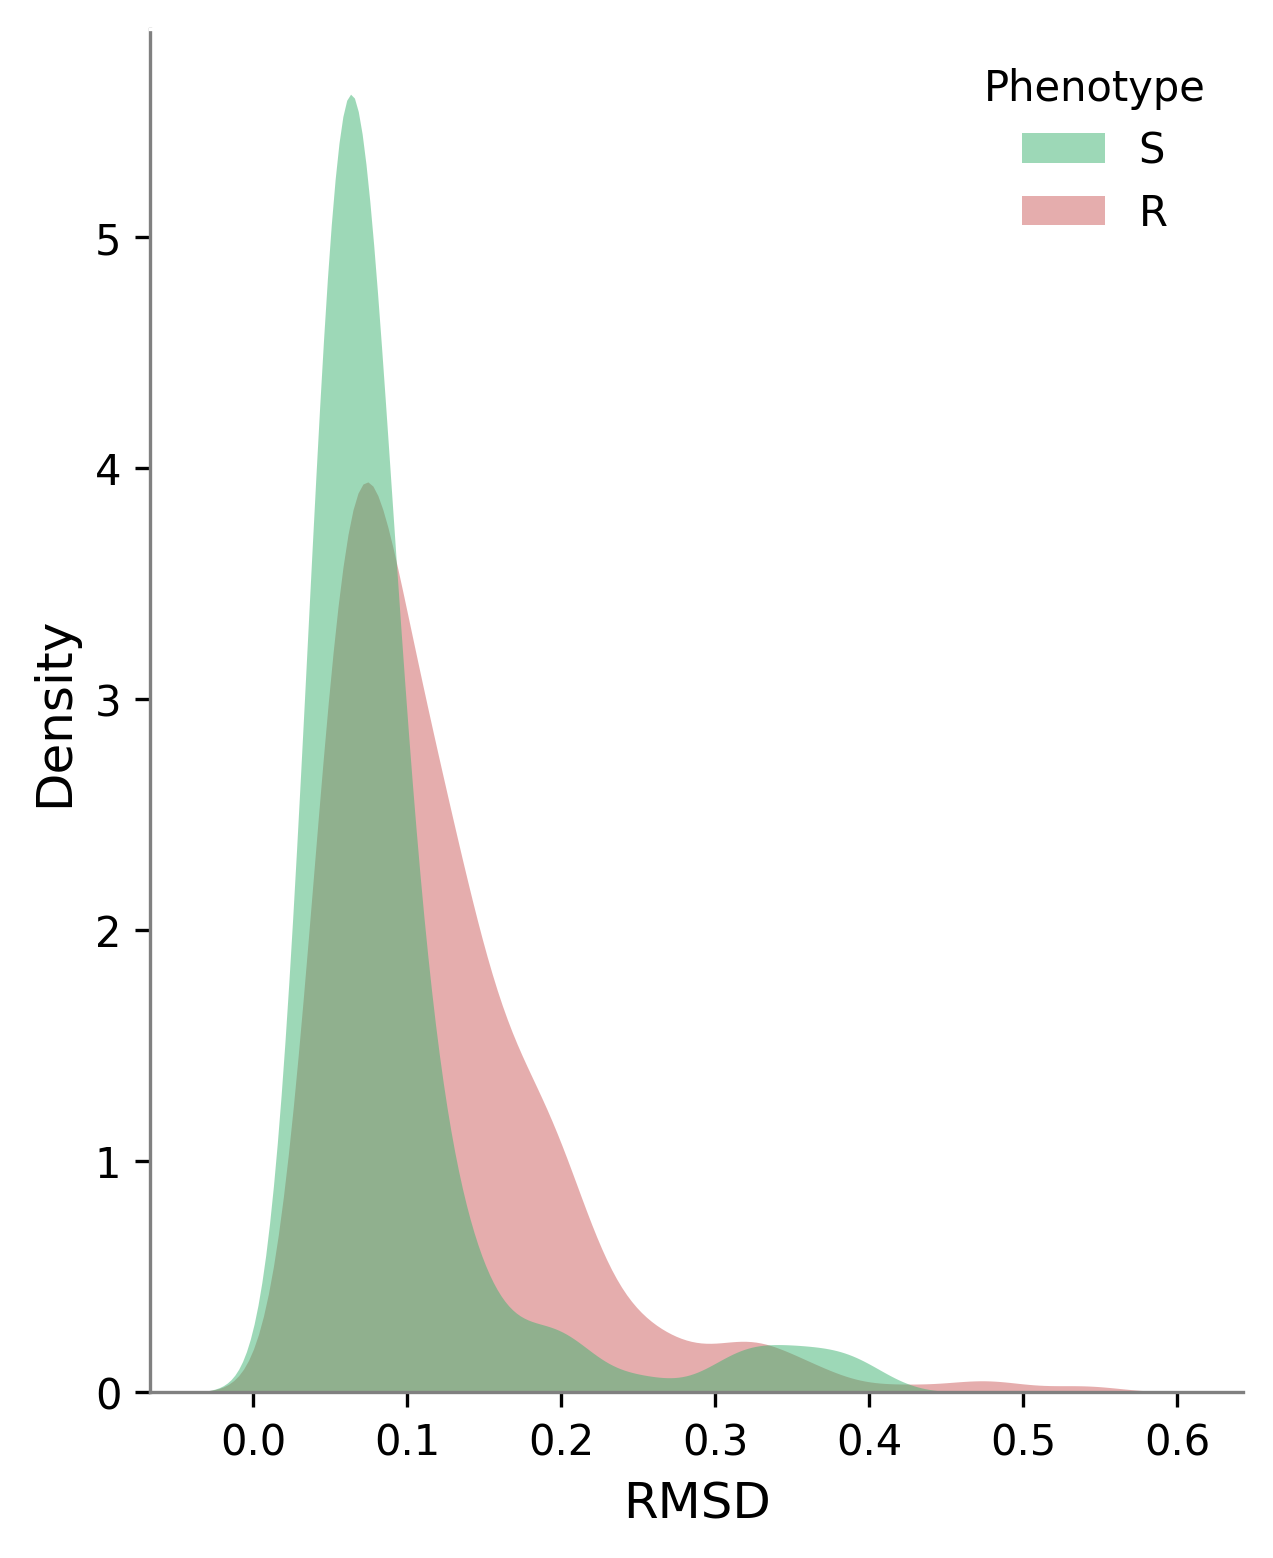

In [24]:
from matplotlib.patches import Patch

data = full_set_df[['phenotype_label', 'RMSD']].rename(columns={'phenotype_label': 'Phenotype'})

legend_elements = [
    Patch(facecolor='mediumseagreen', edgecolor='none', label='S', alpha= 0.5),
    Patch(facecolor='indianred', edgecolor='none', label='R', alpha= 0.5)
]

fig, ax = plt.subplots(figsize=(4.7, 5.9))

sns.kdeplot(data, x='RMSD', 
            # multiple='stack', 
            hue='Phenotype',
            palette={'S': 'mediumseagreen', 'R': 'indianred'},
            fill=True,
            common_norm=True,
            linewidth=0,
            alpha=0.5
            )


plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')


legend = ax.legend(
    handles=legend_elements,
    title='Phenotype',
    frameon=False,    
    loc='upper right' 
)

plt.xlabel('RMSD')
plt.ylabel('Density')

plt.show()

### Boxplot of RMSDs

Show full dataset
Train
Test
All susceptible
All resistant

In [25]:
from scipy.stats import mannwhitneyu, ttest_ind

# test significance of RMSD differences between S and R

group1 = full_set_df[full_set_df['phenotype_label'] == 'S']['RMSD']
group2 = full_set_df[full_set_df['phenotype_label'] == 'R']['RMSD']

# stat, p_value = ttest_ind(group1, group2)
res = mannwhitneyu(group1, group2)

print(f"p = {res[1]}") # probability of observing a difference as large, assuming the null hypothesis (both groups have the same distribution) is true

p = 3.026279670338045e-15


In [30]:
full_set_df

,RMSD,phenotype_label,Dataset
0,0.132045,S,Train Set
1,0.090405,S,Train Set
2,0.093664,R,Train Set
3,0.077379,S,Train Set
4,0.253758,R,Train Set
...,...,...,...
659,0.334187,R,Test Set
660,0.082294,S,Test Set
661,0.067970,S,Test Set
662,0.047777,S,Test Set


/var/folders/l5/vrm1h_ss1_l4hs0jcrxrr_0c0000gn/T/ipykernel_61228/2894918971.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


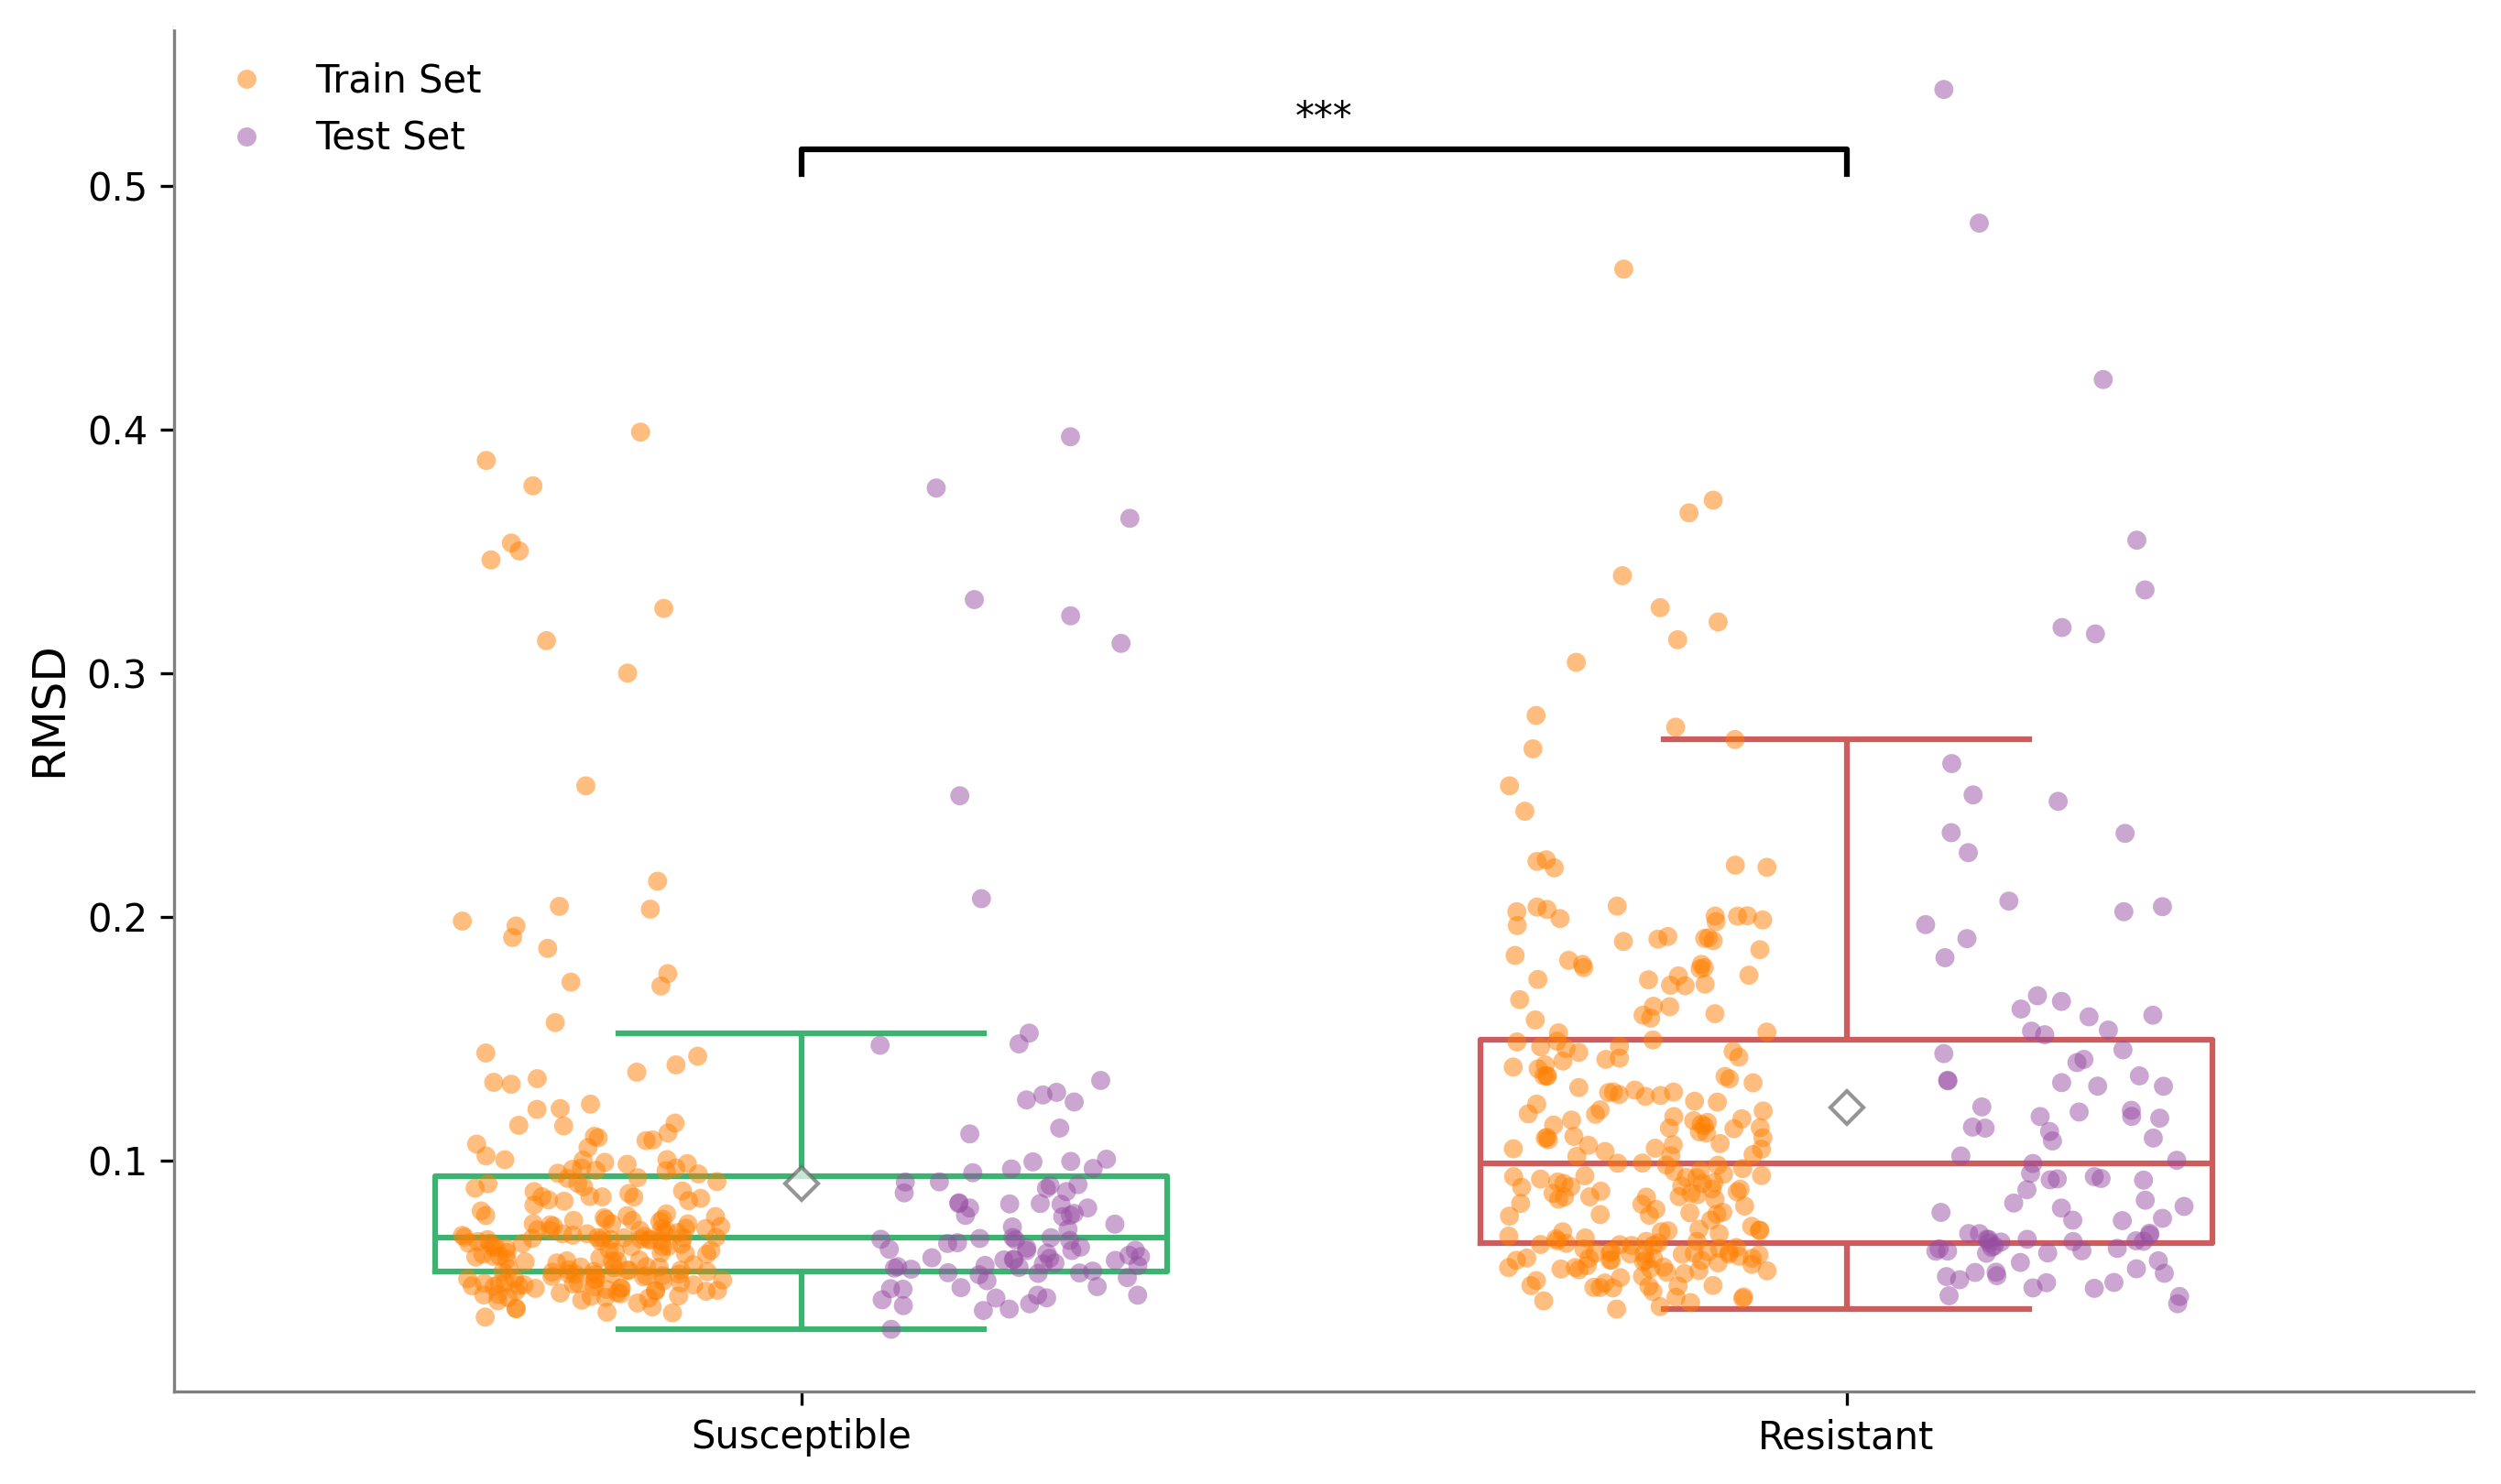

In [31]:
plt.figure(figsize=(9.2, 5.5))

palette = {'S': 'mediumseagreen', 'R': 'indianred'}
dot_palette = {'Train Set': '#ff7f00', 'Test Set': '#984ea3'}


sns.boxplot(
        data=full_set_df, 
        x='phenotype_label', 
        y='RMSD', 
        palette=palette, 
        showmeans=True,
        width=0.7,
        fill=False,
        meanprops={'marker':'D', 'markerfacecolor':'white',
                   'markeredgecolor':'dimgray', 'linestyle':'--',
                   'alpha':0.7},
        showfliers=False,
        )


# Add jittered dots, colored by 'Category'
sns.stripplot(data=full_set_df, x='phenotype_label', y='RMSD', hue='Dataset', palette=dot_palette,
              dodge=True, jitter=0.25, 
              alpha=0.5, 
              size=5)

# plt.yticks(np.arange(0, 0.6, 0.05))
plt.xticks(ticks=[0, 1], labels=['Susceptible', 'Resistant'])

plt.xlim(-0.6, 1.6)

plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')


#  bar to show significant difference due to p-value
x1, x2 = 0, 1   # 'S' and 'R'
y, h, col = 0.505, 0.01, 'black'

# line and p-value
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.005, "***", ha='center', va='bottom', color=col)


legend = plt.legend(title='',
        #    bbox_to_anchor=(1, 1), 
           loc='upper left'
           )

legend.set_frame_on(False)

plt.xlabel('')
plt.ylabel('RMSD')

plt.tight_layout()

plt.show()


In [27]:
full_set_df.groupby('phenotype_label')['RMSD'].mean()

phenotype_label
R    0.121570
S    0.090325
Name: RMSD, dtype: float64

### RMSD by mutation position

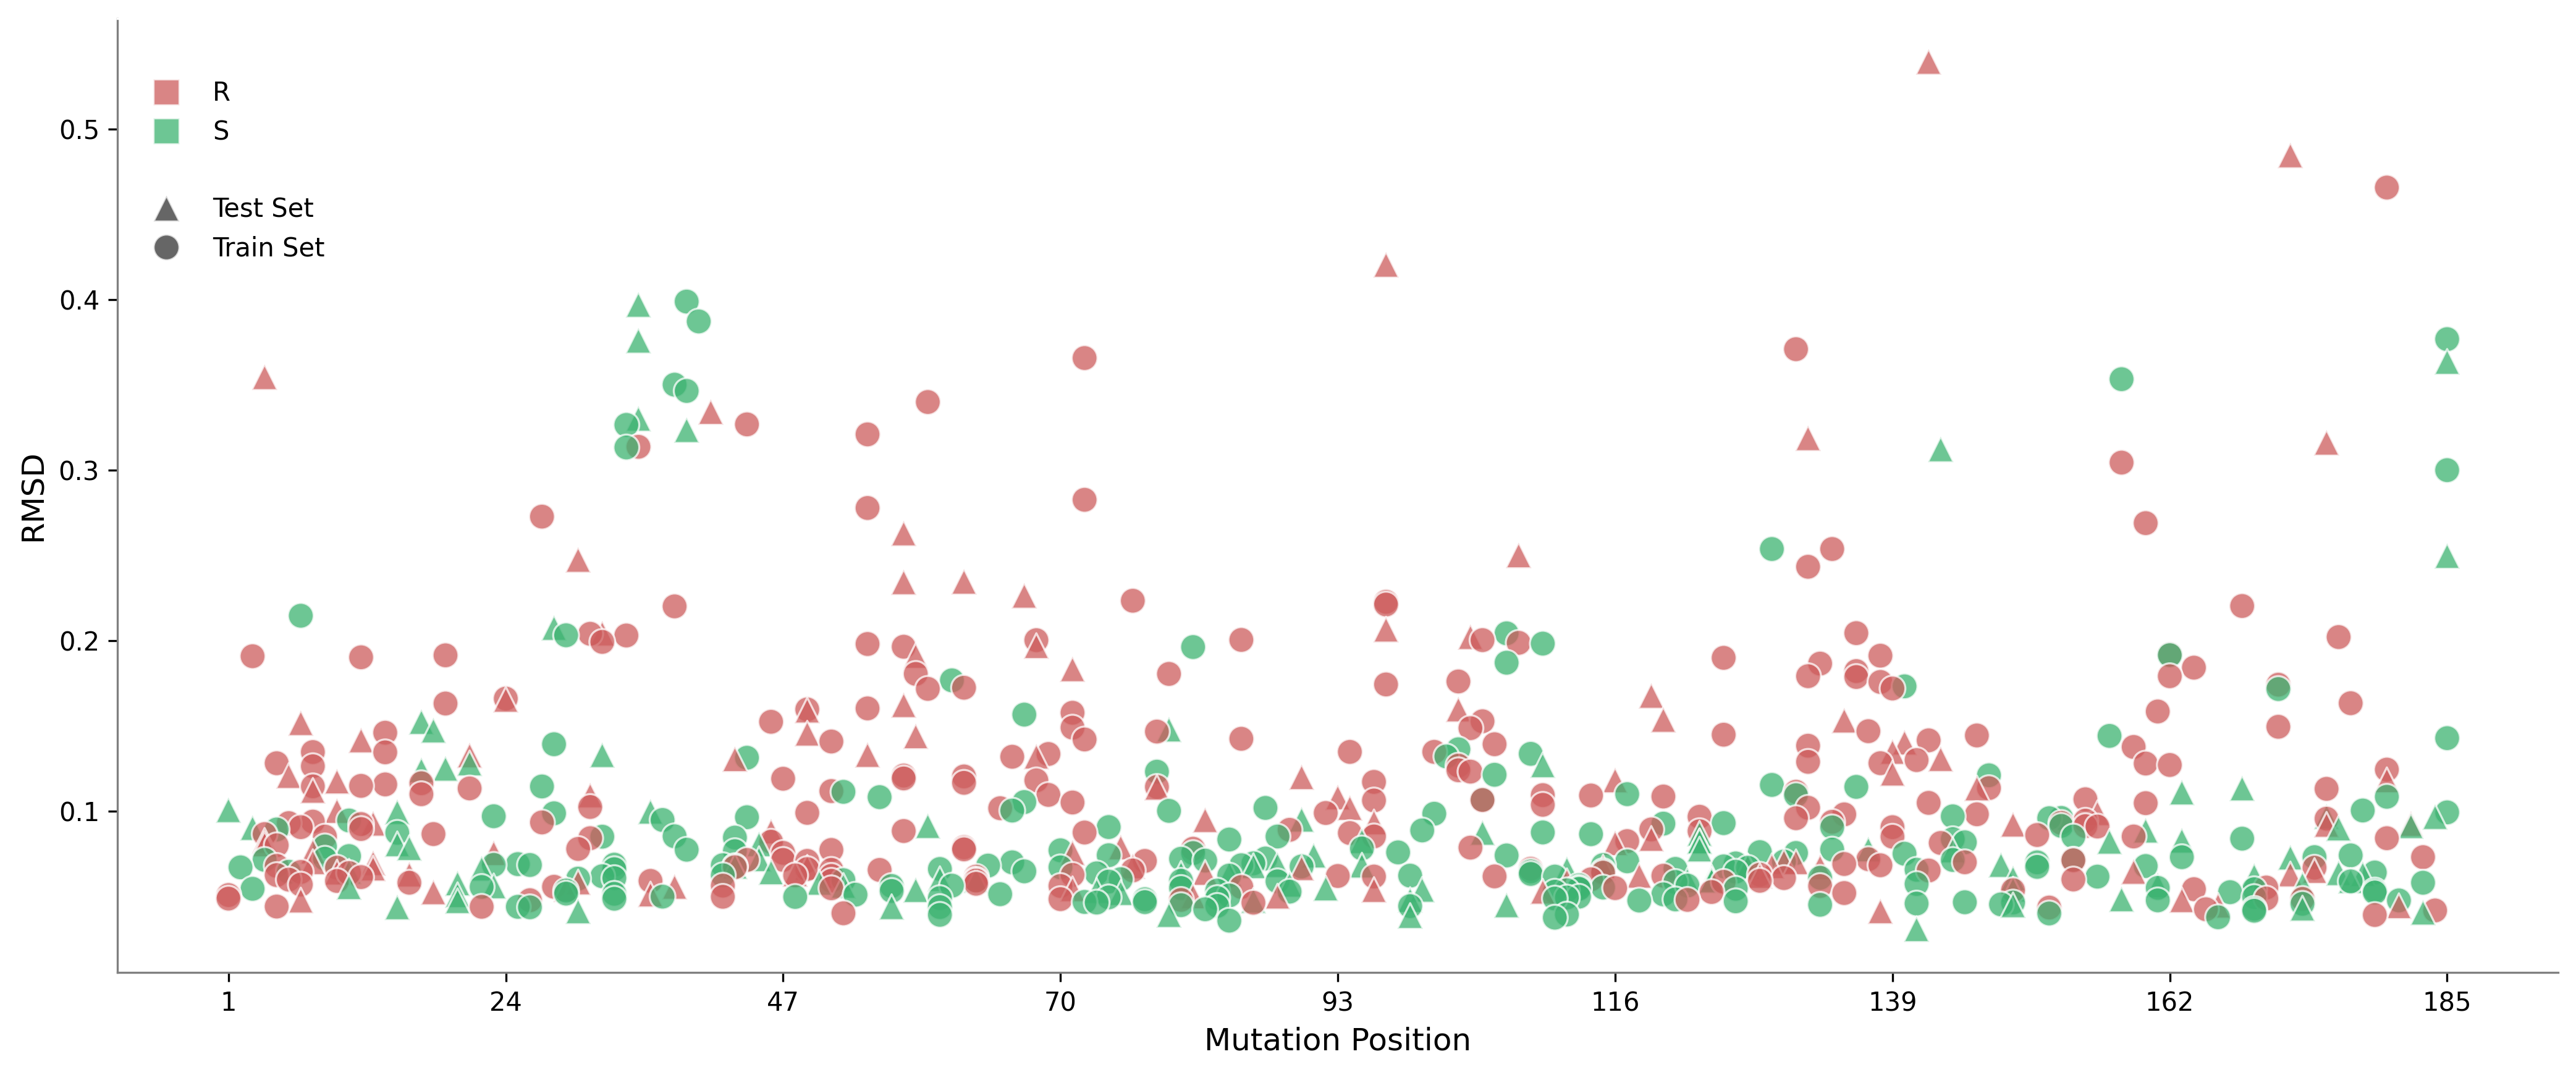

In [28]:
full_set_df_w_mut['mutation_position'] = full_set_df_w_mut['mutation'].str[1:-1].astype(int) # get mutation position

plt.figure(figsize=(14, 5.9))

sns.scatterplot(
    data=full_set_df_w_mut, 
    x='mutation_position', 
    y='RMSD', 
    hue='phenotype_label', 
    style='Dataset', 
    markers={'Train Set': 'o', 'Test Set': '^'}, 
    s=100, 
    palette={'S': 'mediumseagreen', 'R': 'indianred'},
    alpha=0.75,
    )

# plt.yticks(ticks=np.arange(0, 0.6, 0.05))
plt.yticks(ticks=np.arange(0.1, 0.6, 0.1))
plt.xticks(ticks=np.arange(1, 187, step=23))
plt.xlabel('Mutation Position')
plt.ylabel('RMSD')

legend = plt.legend(title='')
legend.set_frame_on(False)
legend.get_texts()[0].set_text('Phenotype')
legend.get_texts()[0].set_visible(False)
legend.get_texts()[3].set_visible(False)


legend.legend_handles[0].set_visible(False)
for handle in legend.legend_handles[1:3]:
    handle.set_marker('s')  # square marker type

plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')


plt.tight_layout()

plt.show()